# Workflow

## Libs

In [1]:
import os
import re
import pickle
import math

import pandas as pd
import numpy as np

import sklearn
from sklearn.linear_model import LinearRegression

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

import plotly.graph_objects as go
import plotly.express as px
from tqdm.auto import tqdm

# My modules
import parsing
import posing
import plotting
import feature_extraction

## Feature Extraction

In [3]:
subject_path = '../data/subjects'

pkls = []

for path, dirs, files in os.walk(subject_path):
    pkls += [os.path.join(path, f) for f in files if f.endswith('.pkl')]

print(f'# pickle files: {len(pkls)}')
pkl_head = '\n'.join(pkls[:10])
print(f"First ten pickle files:\n{pkl_head}")

# pickle files: 2514
First ten pickle files:
../data/subjects\01\01_01.pkl
../data/subjects\01\01_02.pkl
../data/subjects\01\01_03.pkl
../data/subjects\01\01_04.pkl
../data/subjects\01\01_05.pkl
../data/subjects\01\01_06.pkl
../data/subjects\01\01_07.pkl
../data/subjects\01\01_08.pkl
../data/subjects\01\01_09.pkl
../data/subjects\01\01_10.pkl


In [3]:
feature_df = pd.DataFrame()
for pkl in tqdm(pkls):
    df = pd.read_pickle(pkl)
    features = feature_extraction.extract_features(df)
    features.index = [os.path.basename(pkl).replace('.pkl', '')]
    feature_df = pd.concat([feature_df, features])

feature_df.to_json('features.json')

  0%|          | 0/2514 [00:00<?, ?it/s]

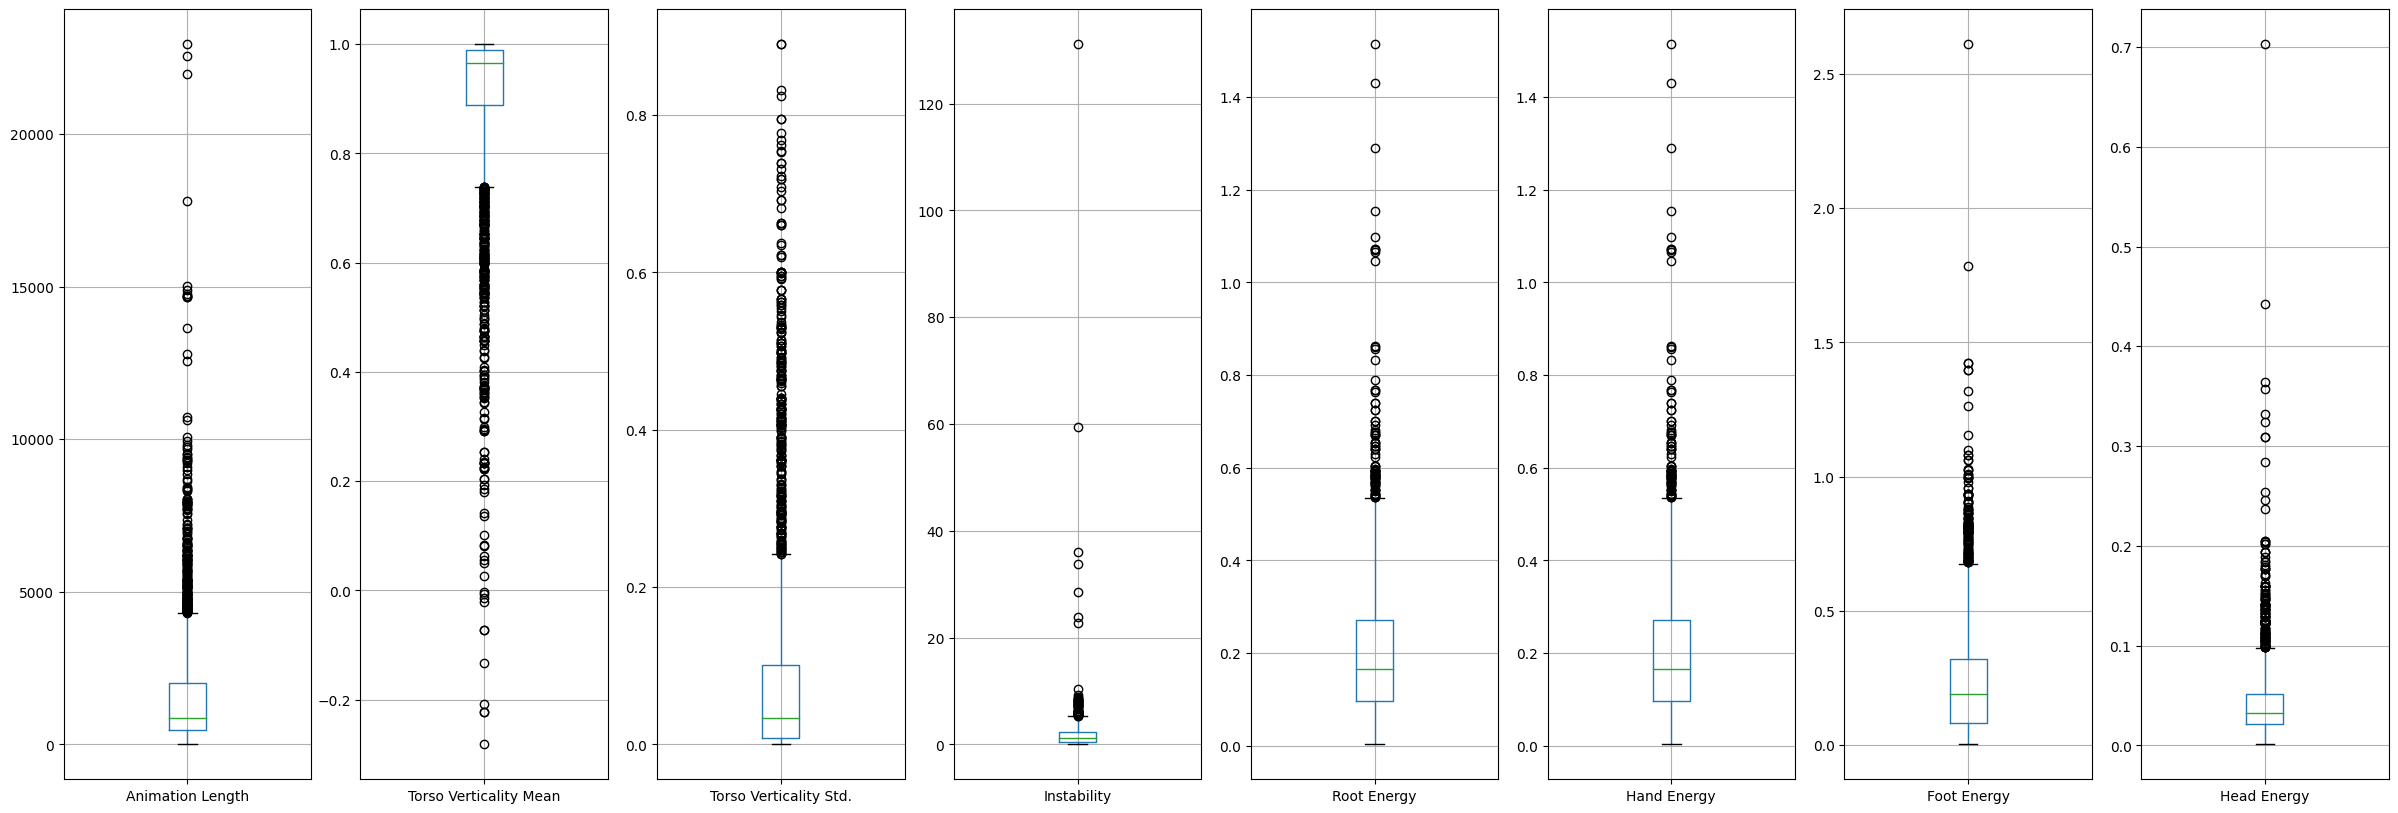

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, len(feature_df.columns), figsize=(30, 10))

for i, col in enumerate(feature_df.columns):
    feature_df.boxplot(col, ax=ax[i])

In [5]:
display(feature_df.corr())
px.imshow(feature_df.corr())

,Animation Length,Torso Verticality Mean,Torso Verticality Std.,Instability,Root Energy,Hand Energy,Foot Energy,Head Energy
Animation Length,1.000000,0.015213,-0.017846,-0.083703,-0.148906,-0.148906,-0.256919,-0.146080
Torso Verticality Mean,0.015213,1.000000,-0.780240,0.009664,-0.219606,-0.219606,-0.132607,-0.487894
Torso Verticality Std.,-0.017846,-0.780240,1.000000,-0.015136,0.300032,0.300032,0.126503,0.619853
Instability,-0.083703,0.009664,-0.015136,1.000000,0.199269,0.199269,0.290377,0.148899
Root Energy,-0.148906,-0.219606,0.300032,0.199269,1.000000,1.000000,0.663679,0.726005
Hand Energy,-0.148906,-0.219606,0.300032,0.199269,1.000000,1.000000,0.663679,0.726005
Foot Energy,-0.256919,-0.132607,0.126503,0.290377,0.663679,0.663679,1.000000,0.566043
Head Energy,-0.146080,-0.487894,0.619853,0.148899,0.726005,0.726005,0.566043,1.000000


In [6]:
print(feature_df.corr().to_markdown())

|                        |   Torso Verticality Mean |   Torso Verticality Std. |   Instability |   Hand Energy |   Foot Energy |   Head Energy |
|:-----------------------|-------------------------:|-------------------------:|--------------:|--------------:|--------------:|--------------:|
| Torso Verticality Mean |                 1        |              -0.939461   |   -0.179308   |      0.190789 |      0.472004 |    -0.499854  |
| Torso Verticality Std. |                -0.939461 |               1          |    0.00694171 |     -0.172404 |     -0.566613 |     0.533551  |
| Instability            |                -0.179308 |               0.00694171 |    1          |     -0.232703 |      0.219031 |    -0.0486273 |
| Hand Energy            |                 0.190789 |              -0.172404   |   -0.232703   |      1        |      0.3542   |     0.275314  |
| Foot Energy            |                 0.472004 |              -0.566613   |    0.219031   |      0.3542   |      1        |  

## Feature Selection

In [25]:
feature_df1 = feature_df[feature_df['Animation Length'] > 1000]
feature_df1 = feature_df1[['Torso Verticality Std.', 'Instability']].dropna()

cuts = {
    col + ' Cut': pd.qcut(feature_df1[col], 2, labels=['Lo ' + col, 'Hi ' + col])
    for col in feature_df1.columns
}

d1 = feature_df1.assign(**cuts)
d1['bin'] = pd.Categorical(d1.filter(regex='Cut').apply(tuple, 1))

print(list(d1.filter(regex='Cut').columns))
d1['bin'].value_counts()

['Torso Verticality Std. Cut', 'Instability Cut']


bin
(Hi Torso Verticality Std., Lo Instability)    327
(Lo Torso Verticality Std., Hi Instability)    327
(Lo Torso Verticality Std., Lo Instability)    229
(Hi Torso Verticality Std., Hi Instability)    228
Name: count, dtype: int64

## Sampling

In [36]:
d1_sample = d1.groupby('bin', group_keys=False).apply(lambda x: x.sample(100))
sample_set = set(d1_sample.index)

In [ ]:
sample_size = 100
sample_frame_dict = {}

for filename in tqdm(sample_set):

    subject, trial = filename.split('_')
    pkl = filename + '.pkl'

    anim = pd.read_pickle(os.path.join(subject_path, subject, pkl))
    num_frames = len(anim.index.get_level_values('frame').unique())
    sample_frame_dict[filename] = np.random.choice(num_frames, size=sample_size, replace=False)
    

In [109]:
input_joints = ['lhand', 'rhand', 'head']
output_joints = ['root', 'thorax', 'lhumerus', 'rhumerus']

data = []

for motion, frames in tqdm(sample_frame_dict.items()):

    def get_arrays(frame_df):
        return np.stack(frame_df.loc[input_joints]['position']), np.stack(frame_df.loc[output_joints]['position'])

    subject, trial = motion.split('_')
    pkl = motion + '.pkl'

    anim = pd.read_pickle(os.path.join(subject_path, subject, pkl))
    sample_df = anim.loc[frames, :]

    for frame, df in sample_df.groupby('frame', group_keys=False):
        data.append(get_arrays(df.droplevel(0)))

  0%|          | 0/400 [00:00<?, ?it/s]

In [123]:
import pickle

with open('sample_set.pkl', 'wb') as f:
    
    data_dict = {
        'sample_set': sample_frame_dict,
        'data': data
    }

    pickle.dump(data_dict, f)

## Training

In [2]:
with open('sample_set.pkl', 'rb') as f:
    data_dict = pickle.load(f)

data_dict

{'sample_set': {'13_34': array([1296,  903,  424,  882,  847,  183,  664,  932,  645,  253,   56,
          690,  584,  425,  885, 1337, 1316, 1080,  259, 1061,  892,  285,
          659,  982,  321, 1410,  138,   11,  374,  785,  418, 1396,  860,
          271, 1048,  408, 1051,  838, 1221,  124,  941,  851,  829,  277,
          793,  910,  841,  542, 1408,  971, 1191,  373,  561, 1360, 1017,
         1026, 1125,  288,  129, 1166,  173,  768,  375,  727,  681, 1071,
          550,  844,  596,  102,  485,  989,   28, 1082,  240,  683,  141,
          244,  171,  335, 1216,  540,  661, 1398, 1067, 1402,  870,  486,
          866,  552,  792,  698,  721, 1349, 1320,  182,  554,  809,  148,
           37]),
  '122_22': array([1063, 2186, 3422, 4938, 3053, 4433, 2040, 2316, 1333,  271, 2333,
         1598, 4621, 1771, 1175, 3068,  380, 1491, 2648, 3637, 2041, 2294,
         1474, 1277, 4614, 3091,  910, 2940, 5215, 4797,  720, 3614, 4492,
         2996, 3502,  168, 2408, 3347, 5135, 3667,

In [4]:
data = data_dict['data']
X = torch.Tensor([i[0] for i in data])
y = torch.Tensor([i[1] for i in data])

dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset)

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):

    def __init__(self):
        super().__init__()

        self.flatten = nn.Flatten()
        self.model = nn.Sequential(
            nn.Linear(9, 12)
        )

    def forward(self, x):
        x = self.flatten(x)
        output = self.model(x)
        return output

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (model): Sequential(
    (0): Linear(in_features=9, out_features=12, bias=True)
  )
)


C:\Users\soppe\AppData\Local\Temp\ipykernel_38336\3089677057.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  X = torch.Tensor([i[0] for i in data])


In [156]:
batch_size = 1000

loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

def train(dataloader, model, loss_fn, optimizer):

    size = len(dataloader.dataset)
    model.train()
    
    for batch, (X, y) in enumerate(dataloader):
        
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred.flatten(), y.flatten())

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % batch_size == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [157]:
epochs = 5
for t in range(epochs):

    print(f"Epoch {t+1}\n-------------------------------")
    train(dataloader, model, loss_fn, optimizer)

print("Done!")

Epoch 1
-------------------------------
loss: 206.970490  [    1/40000]
loss: 2.871476  [ 1001/40000]
loss: 4.485736  [ 2001/40000]
loss: 1.575345  [ 3001/40000]
loss: 6.752933  [ 4001/40000]
loss: 8.656054  [ 5001/40000]
loss: 0.444041  [ 6001/40000]
loss: 15.768387  [ 7001/40000]
loss: 9.125391  [ 8001/40000]
loss: 23.353447  [ 9001/40000]
loss: 3.876527  [10001/40000]
loss: 1.123612  [11001/40000]
loss: 0.231244  [12001/40000]
loss: 43.511536  [13001/40000]
loss: 1.563767  [14001/40000]
loss: 8.249897  [15001/40000]
loss: 0.690991  [16001/40000]
loss: 7.928971  [17001/40000]
loss: 2.568123  [18001/40000]
loss: 2.842044  [19001/40000]
loss: 3.190658  [20001/40000]
loss: 3.629410  [21001/40000]
loss: 2.361099  [22001/40000]
loss: 1.622339  [23001/40000]
loss: 2.459388  [24001/40000]
loss: 7.757489  [25001/40000]
loss: 1.579504  [26001/40000]
loss: 0.289487  [27001/40000]
loss: 1.690102  [28001/40000]
loss: 2.625218  [29001/40000]
loss: 0.820722  [30001/40000]
loss: 10.511678  [31001/4

## Modelling and Prediction

In [32]:
def get_frames(motion, frames=None, subject_path='../data/subjects/'):
    subject, trial = motion.split('_')
    pkl = motion + '.pkl'

    anim_df = pd.read_pickle(os.path.join(subject_path, subject, pkl))
    if isinstance(frames, list):
        anim_df = anim_df.loc[frames, :]
    elif frames is not None:
        anim_df = anim_df.loc[frames]
    return anim_df

def frame_to_sample(
    frame_df, 
    input_joints=['lhand', 'rhand', 'head'],
    output_joints=['root', 'thorax', 'lhumerus', 'rhumerus'],
    flatten=True
):
    
    if isinstance(frame_df.index, pd.MultiIndex):
        samples = [
            frame_to_sample(df.droplevel(0), input_joints, output_joints, flatten) 
            for i, df in frame_df.groupby('frame', group_keys=False)
        ]
        return [i[0] for i in samples], [i[1] for i in samples]
        
    else:
        X, y = np.stack(frame_df.loc[input_joints]['position']), np.stack(frame_df.loc[output_joints]['position'])
        return (X, y) if not flatten else (X.flatten(), y.flatten())

def sample_to_frame(
    X,
    y,
    input_joints=['lhand', 'rhand', 'head'],
    output_joints=['root', 'thorax', 'lhumerus', 'rhumerus']
):
    
    if isinstance(X, list):
        return pd.concat([
            sample_to_frame(i, j, input_joints, output_joints)
            for i, j in zip(X, y)
        ], keys=range(len(X)))
    
    return pd.DataFrame(
        {'position': list(np.concatenate([X.reshape(3, 3), y.reshape(4, 3)]))}, 
        index=input_joints + output_joints
    )

def plot_pose(pose_df, prediction_df=None):
    '''
    Creates a plot showing a pose_df, which should wither be a rest pose or a pose with a motion applied.

    Arguments:
    pose_df - Dataframe containing pose information. Must include at least the position, rotation, direction, length, and children of joints.
    '''
    # pose = pose_df
    # if prediction:
    #     pose.index = [i + '_pred' for i in pose_df.index]
    #     pose.index.name = 'joint'

    frame = plotting.get_pose_frame(pose_df, joint_size=5, joint_color=None)

    data = frame.data if prediction_df is None else frame.data + plotting.get_pose_frame(prediction_df, joint_size=10, joint_color='green').data

    fig = go.Figure(
        data=data
    )

    root_position = pose_df.loc['root', 'position']

    fig.update_layout(
        scene={
            'aspectmode': 'cube',
            'xaxis': {'range': (root_position[2]-20, root_position[2]+20)},
            'yaxis': {'range': (root_position[0]-20, root_position[0]+20)},
            'zaxis': {'range': (root_position[1]-20, root_position[1]+20)},
            'xaxis_title': 'z',
            'yaxis_title': 'x',
            'zaxis_title': 'y'
        },
    )

    return fig


In [40]:
with open('sample_set.pkl', 'rb') as f:
    data_dict = pickle.load(f)

print(f'{len(data_dict["data"])} samples found.')
data_dict['data'][0]

40000 samples found.


(array([[ 4.48630126, 14.60984202, 11.70924893],
        [ 6.69445235, 17.25956217,  0.67006183],
        [ 4.9069139 , 27.96206962,  9.03149784]]),
 array([[ 7.43948   , 18.8115    ,  7.96248   ],
        [ 6.43824637, 22.66193914,  8.47996816],
        [ 5.08035883, 25.37332453, 12.2015386 ],
        [ 6.38015729, 26.42303386,  5.95630123]]))

In [42]:
# Train model

data = data_dict['data']
X = np.stack([i[0].flatten() for i in data])
y = np.stack([i[1].flatten() for i in data])

class LinearModel(LinearRegression):

    def __call__(self, X):
        
        if len(X.shape) == 1:
            return self.predict([X])
        else:
            return self.predict(X)
    
linear_model = LinearModel().fit(X, y)
linear_model.score(X, y)

0.9676158957785682

In [52]:
# Predict

frame_df = get_frames('87_03', frames=150)
X, y = frame_to_sample(frame_df)
prediction = sample_to_frame(X, linear_model(X))
prediction.index.name = 'joint'

# Plot

plot_pose(frame_df, prediction)

In [56]:
prediction

,position
joint,
lhand,"[9.703299621745769, 24.693551651812026, -12.06..."
rhand,"[8.292526005975152, 27.019891008579616, 8.8436..."
head,"[5.415106405284613, 25.692455173353796, -1.785..."
root,"[2.7942743330324915, 17.693102199109326, -2.18..."
thorax,"[4.045846793830306, 21.05410191830003, -1.9810..."
lhumerus,"[5.565126199737192, 23.774738756489594, -7.661..."
rhumerus,"[4.4025943515580455, 24.008667266628176, 4.054..."
